In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from gurobipy import GRB
import glob
import pickle

# Model information

In [3]:
from networkx.utils import graphs_equal
def assert_equivalence(path):
    models = {}
    for model in glob.glob(f'{path}*.pickle'):
        model_name = model.split('model_')[1].split('_')[0]
        if model_name not in models:
            models[model_name] = [model]
        else:
            models[model_name].append(model)
    for k in models:
        if 'bpic' not in k and 'greps' not in k:
            continue
        m_base = None
        with open(models[k][0], 'rb') as handle:
            m_base = pickle.load(handle)
        for m in models[k][1:]:
            m_current = None
            with open(m, 'rb') as handle:
                m_current = pickle.load(handle)
            assert graphs_equal(m_current,m_base), f'{models[k][0]}, {m}, m_current.nodes()'
        print("Is equal", k)
assert_equivalence('out/models/')

Is equal bpic17-before
Is equal greps
Is equal bpic17-after
Is equal bpic17-both
Is equal bpic12


In [4]:
def transform_model_name(s):
    if 'greps' in s:
        return 'Greps'
    if 'bpic12' in s:
        return "BPIC'12"
    if 'bpic17-before' in s:
        return "BPIC'17-1"
    if 'bpic17-after' in s:
        return "BPIC'17-2"
    if 'bpic17-both' in s:
        return "BPIC'17"
    if 'spotify' in s:
        if s[-4:-2] == "00":
            return 'MSSD100'
        return f'MSSD{s[-4:-2]}'
    assert False, s


In [5]:
def model_information(path):
    print()
    info_dict = {'states' : {}, 'transitions' : {}, 'max_degree' : {}}
    for model in glob.glob(f'{path}*.pickle'):
        model_name = model.split('model_')[1].split('_')[0]
        model_name = transform_model_name(model_name)
        with open(model, 'rb') as handle:
            model = pickle.load(handle)
        if model_name not in info_dict['states']:
            info_dict['transitions'][model_name] = []
            info_dict['states'][model_name] = []
            info_dict['max_degree'][model_name] = []
        info_dict['states'][model_name].append(len(model.nodes()))
        info_dict['transitions'][model_name].append(len(model.edges()))
        degree_sequence = sorted((d for n, d in model.degree()), reverse=True)
        dmax = max(degree_sequence)
        info_dict['max_degree'][model_name].append(dmax)
    for k in info_dict:
        for k_inner in info_dict[k]:
            info_dict[k][k_inner] = sum(info_dict[k][k_inner])/len(info_dict[k][k_inner])
    print(info_dict)
    df = pd.DataFrame(data = info_dict)
    # df = pd.DataFrame(data={'States' : info_dict['states'], 'Transitions' : info_dict['transitions']}, index = info_dict['states'].keys())
    df.rename(columns = {'states' : 'States', 'transitions' : 'Transitions'}, inplace=True)
    
    s = ['Greps', "BPIC'12", "BPIC'17"]
    s.extend([f'MSSD{i*10}' for i in range(1,11)])
    print(s)
    df = df.reindex(s)
    
    print(df.to_latex(index=True,
                formatters={"name": str.upper},
                float_format="{:.1f}".format, bold_rows = True,
    ))
    
    return df
model_information('out/models/')


{'states': {"BPIC'17-1": 123.0, 'Greps': 64.0, 'MSSD30': 9378.6, 'MSSD40': 10603.4, 'MSSD90': 14334.0, 'MSSD60': 12456.2, 'MSSD10': 5702.8, 'MSSD80': 13804.2, 'MSSD100': 14860.0, "BPIC'17-2": 142.0, "BPIC'17": 158.0, 'MSSD70': 13213.2, 'MSSD20': 7971.6, 'MSSD50': 11581.2, "BPIC'12": 129.0}, 'transitions': {"BPIC'17-1": 211.0, 'Greps': 76.0, 'MSSD30': 19718.0, 'MSSD40': 22585.8, 'MSSD90': 31905.5, 'MSSD60': 27106.1, 'MSSD10': 11341.5, 'MSSD80': 30547.4, 'MSSD100': 33266.0, "BPIC'17-2": 243.0, "BPIC'17": 292.0, 'MSSD70': 28984.2, 'MSSD20': 16247.5, 'MSSD50': 25016.5, "BPIC'12": 288.0}, 'max_degree': {"BPIC'17-1": 13.0, 'Greps': 6.0, 'MSSD30': 3397.3, 'MSSD40': 3857.1, 'MSSD90': 5403.8, 'MSSD60': 4612.0, 'MSSD10': 1952.6, 'MSSD80': 5171.3, 'MSSD100': 5622.0, "BPIC'17-2": 17.0, "BPIC'17": 19.0, 'MSSD70': 4918.7, 'MSSD20': 2794.0, 'MSSD50': 4249.0, "BPIC'12": 28.0}}
['Greps', "BPIC'12", "BPIC'17", 'MSSD10', 'MSSD20', 'MSSD30', 'MSSD40', 'MSSD50', 'MSSD60', 'MSSD70', 'MSSD80', 'MSSD90', 'MS

/tmp/ipykernel_16120/469189313.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=True,


,States,Transitions,max_degree
Greps,64.0,76.0,6.0
BPIC'12,129.0,288.0,28.0
BPIC'17,158.0,292.0,19.0
MSSD10,5702.8,11341.5,1952.6
MSSD20,7971.6,16247.5,2794.0
MSSD30,9378.6,19718.0,3397.3
MSSD40,10603.4,22585.8,3857.1
MSSD50,11581.2,25016.5,4249.0
MSSD60,12456.2,27106.1,4612.0
MSSD70,13213.2,28984.2,4918.7


# Greps and BPIC runtimes

In [6]:
import numpy as np
def plot_results_df(path):
    df = pd.read_csv(path)
    df = df[df['id'] == 0]
    
    df['status'] = df['status'].astype('category')
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    
    
    df['target_prob_quantile'] = pd.qcut(df['target_prob'], 10, labels=False)
    df_grouped = df.groupby('model_name')['time'].agg(['mean','std', 'min', 'max']).reset_index()
    
    df_grouped.rename(columns = {'mean' : 'mean(t)', 'std' : 'std(t)', 'min' : 'min(t)', 'max' : 'max(t)', 'model_name' : 'Model'}, inplace=True)
    
    
    df_groped_not_agg = df.groupby(['model_name', 'status']).size()
    recorded_status = df['status'].values
    
    df_grouped['Opt.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.OPTIMAL].values if GRB.OPTIMAL in recorded_status else 0
    df_grouped['Inf.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.INFEASIBLE].values if GRB.INFEASIBLE in recorded_status else 0
    df_grouped['T.O.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.TIME_LIMIT].values if GRB.TIME_LIMIT in recorded_status else 0 
    df_grouped['M.O.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.MEM_LIMIT].values if GRB.MEM_LIMIT in recorded_status else 0
    
    df_grouped['T.O.'].astype(object) 
    
    #df = df.groupby('model_name').mean().reset_index()
    
    print(tabulate(df_grouped.round(2), headers='keys', tablefmt='psql'))
    df_grouped.set_index("Model", inplace=True)
    df_grouped = df_grouped.reindex(['Greps', "BPIC'12", "BPIC'17"])
    
    print(df_grouped.to_latex(index=True,
                formatters={"name": str.upper},
                float_format="{:.2f}".format, bold_rows = True,
    ))
        
plot_results_df('out/results_div_bpic.csv')

+----+---------+-----------+----------+----------+----------+--------+--------+--------+--------+
|    | Model   |   mean(t) |   std(t) |   min(t) |   max(t) |   Opt. |   Inf. |   T.O. |   M.O. |
|----+---------+-----------+----------+----------+----------+--------+--------+--------+--------|
|  0 | BPIC'12 |      0.79 |     0.94 |     0.04 |     4.24 |    110 |      0 |      0 |      0 |
|  1 | BPIC'17 |      1    |     1.06 |     0.01 |     5.01 |    100 |     10 |      0 |      0 |
|  2 | Greps   |      0.01 |     0.01 |     0.01 |     0.05 |     90 |     20 |      0 |      0 |
+----+---------+-----------+----------+----------+----------+--------+--------+--------+--------+
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  mean(t) &  std(t) &  min(t) &  max(t) &  Opt. &  Inf. &  T.O. &  M.O. \\
\textbf{Model  } &          &         &         &         &       &       &       &       \\
\midrule
\textbf{Greps  } &     0.01 &    0.01 &    0.01 &    0.05 &    90 &    20 &     0 &     0 \\
\tex

/tmp/ipykernel_16120/4047155972.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_grouped.to_latex(index=True,


In [7]:
import numpy as np
def plot_results_df(path):
    df = pd.read_csv(path)
    df = df[df['id'] == 0]
    
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['target_prob_quantile'], bins = pd.cut(df['target_prob'], bins = 4, labels=False, retbins=True)
    print(np.round(bins,2))
    df_grouped = df.groupby(['model_name', 'target_prob_quantile'])['time'].agg(['mean','std', 'min', 'max']).reset_index()
    # print(df.set_index(['model_name', 'target_prob_quantile']).unstack(level=0))
    
    df_grouped = df_grouped.round(2)
    
    df_grouped['combined'] = df_grouped[['mean','std', 'min', 'max']].apply(lambda row: f'{row[0]}({row[1]}) : <= {row[3]}', axis=1)
    df_grouped.rename(columns = {'mean' : 'mean(t)', 'std' : 'std(t)', 'min' : 'min(t)', 'max' : 'max(t)', 'model_name' : 'Model'}, inplace=True)
    
    # df_pivot = df_grouped.pivot(index='model_name', columns='target_prob_quantile', values='combined')
    df_pivot = df_grouped.pivot(index='Model', columns='target_prob_quantile', values=['mean(t)', 'std(t)', 'min(t)', 'max(t)'])
    columns = [[('mean(t)', i), ('std(t)', i), ('min(t)', i), ('max(t)', i)] for i in range(0,4)]
    columns = [i for c in columns for i in c]
    df_pivot = df_pivot[columns]
    
    #df_pivot.set_index('Model')
    df_pivot.sort_index(key = lambda x: x.str.len(), inplace=True)
    
    print(tabulate(df_pivot.round(2), headers='keys', tablefmt='psql'))
    
    # print(tabulate(df_grouped.round(2), headers='keys', tablefmt='psql'))
    
    df_pivot = df_pivot.reindex(['Greps', "BPIC'12", "BPIC'17"])
    print(df_pivot.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format, bold_rows=True
    ).replace("<=", "$\leq$"))
    
plot_results_df('out/results_div_bpic.csv')

[-0.    0.25  0.5   0.75  1.  ]
+---------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+
| Model   |   ('mean(t)', 0) |   ('std(t)', 0) |   ('min(t)', 0) |   ('max(t)', 0) |   ('mean(t)', 1) |   ('std(t)', 1) |   ('min(t)', 1) |   ('max(t)', 1) |   ('mean(t)', 2) |   ('std(t)', 2) |   ('min(t)', 2) |   ('max(t)', 2) |   ('mean(t)', 3) |   ('std(t)', 3) |   ('min(t)', 3) |   ('max(t)', 3) |
|---------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------|
| Greps   |             0.01 |            0    |        

/tmp/ipykernel_16120/2946764109.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_pivot.to_latex(index=True,


# Spotify runtimes

In [8]:
spotify_path = 'out/results_spotify_1000-10000.csv'

In [9]:
def plot_results_df(path):
    df = pd.read_csv(path)
    df['status'] = df['status'].astype('category')
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['target_prob_quantile'] = pd.qcut(df['target_prob'], 3, labels=False)
    df_grouped = df.groupby('model_name')['time'].agg(['mean','std', 'min', 'max']).reset_index()
    
    s = df_grouped['model_name'].str.len().sort_values().index
    
    df_grouped.rename(columns = {'mean' : 'mean(t)', 'std' : 'std(t)', 'min' : 'min(t)', 'max' : 'max(t)', 'model_name' : 'Model'}, inplace=True)
    
    
    df_groped_not_agg = df.groupby(['model_name', 'status']).size()
    print(df_groped_not_agg)
    recorded_status = df['status'].values
    
    df_grouped['Opt.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.OPTIMAL].values if GRB.OPTIMAL in recorded_status else 0
    df_grouped['Inf.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.INFEASIBLE].values if GRB.INFEASIBLE in recorded_status else 0
    df_grouped['T.O.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.TIME_LIMIT].values if GRB.TIME_LIMIT in recorded_status else 0 
    df_grouped['M.O.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.MEM_LIMIT].values if GRB.MEM_LIMIT in recorded_status else 0
    df_grouped['Sub.O.'] = df_groped_not_agg.loc[df_grouped['Model'].values, GRB.SUBOPTIMAL].values if GRB.SUBOPTIMAL in recorded_status else 0
    
    df_grouped.loc[df_grouped['max(t)'] >= df['timeout'].values[0], 'max(t)'] = 'T.O.'
    
    df_grouped = df_grouped.reindex(s)
    #df = df.groupby('model_name').mean().reset_index()
    print(tabulate(df_grouped.round(2), headers='keys', tablefmt='psql'))
    
    print(df_grouped.to_latex(index=False,
                formatters={"name": str.upper},
                float_format="{:.2f}".format, bold_rows = True
    ))
        
plot_results_df(spotify_path)

model_name  status
MSSD10      2         710
            3         388
            9           2
            13          0
MSSD100     2         700
            3         100
            9         300
            13          0
MSSD20      2         707
            3         343
            9          41
            13          9
MSSD30      2         703
            3         320
            9          60
            13         17
MSSD40      2         700
            3         193
            9         207
            13          0
MSSD50      2         700
            3         149
            9         251
            13          0
MSSD60      2         700
            3         123
            9         277
            13          0
MSSD70      2         700
            3         131
            9         269
            13          0
MSSD80      2         700
            3         103
            9         297
            13          0
MSSD90      2         700
            3      

/tmp/ipykernel_16120/1587602864.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_grouped.to_latex(index=False,


In [10]:
def plot_results_df(path):
    df = pd.read_csv(path)
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['target_prob_quantile'], bins = pd.cut(df['target_prob'], bins = 6, labels=False, retbins=True)
    print(np.round(bins, 2))
    
    # df.groupby(['model_name', 'target_prob_quantile', 'status']).size().unstack(fill_value=0)
        
    df_grouped = df.groupby(['model_name', 'target_prob_quantile'])['time'].agg(['mean','std', 'min', 'max']).reset_index()
    
    df_help = df.groupby(['target_prob_quantile', 'model_name', 'status']).size().unstack(fill_value=0).reset_index()

    # print(df_help)
    # df_merged = df_grouped.merge(df_help, on = ['model_name', 'target_prob_quantile'])
    
    df_grouped = df_grouped.round(0)
        
    # df_grouped['combined'] = df_grouped[['mean','std', 'min', 'max']].apply(lambda row: f'{row[0]}({row[1]}) : <= [{row[2]}, {row[3]}]', axis=1)
    df_grouped.rename(columns = {'mean' : 'mean(t)', 'std' : 'std(t)', 'min' : 'min(t)', 'max' : 'max(t)', 'model_name' : 'Model'}, inplace=True)
    df_grouped.loc[df_grouped['max(t)'] >= df['timeout'].values[0], 'max(t)'] = 'T.O.'
    df_grouped.loc[df_grouped['min(t)'] >= df['timeout'].values[0], 'min(t)'] = 'T.O.'
    df_grouped.loc[df_grouped['mean(t)'] >= df['timeout'].values[0], 'mean(t)'] = 'T.O.'
    
    df_pivot = df_grouped
    df_pivot = df_grouped.pivot(index='Model', columns='target_prob_quantile', values=['mean(t)', 'std(t)', 'min(t)', 'max(t)'])
    columns = [[('mean(t)', i), ('std(t)', i), ('min(t)', i), ('max(t)', i)] for i in range(0,6)]
    columns = [i for c in columns for i in c]
    df_pivot = df_pivot[columns]
    
    #df_pivot.set_index('Model')
    df_pivot.sort_index(key = lambda x: x.str.len(), inplace=True)
    # df_pivot.sort_values(['Model', 'target_prob_quantile'], ascending = True, inplace = True, key = lambda x: (x.str.len() if x.dtype == 'object' else x))
    
    
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    print(tabulate(df_pivot.round(2), headers='keys', tablefmt='psql'))
    
    # print(tabulate(df_grouped.round(2), headers='keys', tablefmt='psql'))
    print(df_pivot.to_latex(index=True,
                  formatters={"name": str.upper},
                   bold_rows=True
    ))
    #.replace("<=", "$\leq$"))
    
plot_results_df(spotify_path)

[-0.    0.17  0.33  0.5   0.67  0.83  1.  ]
+---------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+
| Model   |   ('mean(t)', 0) |   ('std(t)', 0) |   ('min(t)', 0) | ('max(t)', 0)   | ('mean(t)', 1)   |   ('std(t)', 1) | ('min(t)', 1)   | ('max(t)', 1)   |   ('mean(t)', 2) |   ('std(t)', 2) |   ('min(t)', 2) |   ('max(t)', 2) |   ('mean(t)', 3) |   ('std(t)', 3) |   ('min(t)', 3) |   ('max(t)', 3) |   ('mean(t)', 4) |   ('std(t)', 4) |   ('min(t)', 4) |   ('max(t)', 4) |   ('mean(t)', 5) |   ('std(t)', 5) |   ('min(t)', 5) |   ('max(t)', 5) |
|---------+------------------+-----------------+--------

/tmp/ipykernel_16120/3117738609.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_pivot.to_latex(index=True,


\begin{tabular}{lllllllllllllllllllllllll}
\toprule
{} & mean(t) & std(t) & min(t) & max(t) & mean(t) & std(t) &  min(t) & max(t) & mean(t) & std(t) & min(t) & max(t) & mean(t) & std(t) & min(t) & max(t) & mean(t) & std(t) & min(t) & max(t) & mean(t) & std(t) & min(t) & max(t) \\
\textbf{target\_prob\_quantile} &       0 &      0 &      0 &      0 &       1 &      1 &       1 &      1 &       2 &      2 &      2 &      2 &       3 &      3 &      3 &      3 &       4 &      4 &      4 &      4 &       5 &      5 &      5 &      5 \\
\textbf{Model  } &         &        &        &        &         &        &         &        &         &        &        &        &         &        &        &        &         &        &        &        &         &        &        &        \\
\midrule
\textbf{MSSD10 } &   39.00 &  40.00 &   0.00 & 128.00 &  266.00 & 267.00 &   73.00 &   T.O. &    1.00 &   0.00 &   1.00 &   2.00 &    1.00 &   0.00 &   1.00 &   2.00 &    1.00 &   0.00 &   1.00 &   2.00 &    1

In [11]:
def plot_results_df(path):
    df = pd.read_csv(path)
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['target_prob_quantile'] = pd.cut(df['target_prob'], 6, labels=False)
    df.groupby(['model_name', 'target_prob_quantile', 'status']).size().unstack(fill_value=0)
    df_grouped = df.groupby(['model_name', 'target_prob_quantile'])['time'].agg(['mean','std', 'min', 'max']).reset_index()
    
    df_help = df.groupby(['target_prob_quantile', 'model_name', 'status']).size().unstack(fill_value=0).reset_index()

    print(df_help)
    df_merged = df_grouped.merge(df_help, on = ['model_name', 'target_prob_quantile'])
    
    df_grouped = df_merged.round(2)
    
    # df_grouped['combined'] = df_grouped[['mean','std', 'min', 'max']].apply(lambda row: f'{row[0]}({row[1]}) : <= [{row[2]}, {row[3]}]', axis=1)
    print(df_grouped.columns)
    df_grouped.rename(columns = {'mean' : 'mean(t)', 'std' : 'std(t)', 'min' : 'min(t)', 'max' : 'max(t)', 'model_name' : 'Model', GRB.OPTIMAL : 'Optimal', GRB.TIME_LIMIT : 'Timeout', GRB.INFEASIBLE : 'Infeasible', GRB.SUBOPTIMAL : 'Suboptimal'}, inplace=True)
    df_grouped.loc[df_grouped['max(t)'] >= df['timeout'].values[0], 'max(t)'] = 'T.O.'
    
    df_pivot = df_grouped 
    df_pivot = df_grouped.pivot(index='Model', columns='target_prob_quantile', values=['Optimal', 'Timeout', 'Infeasible', 'Suboptimal'])
    print(df_pivot.columns)
    columns = [[('Optimal', i), ('Infeasible', i), ('Timeout', i), ('Suboptimal', i)] for i in range(0,6)]
    columns = [i for c in columns for i in c]
    df_pivot = df_pivot[columns]
    
    #df_pivot.set_index('Model')
    df_pivot.sort_index(key = lambda x: x.str.len(), inplace=True)
    # df_pivot.sort_values(['Model', 'target_prob_quantile'], ascending = True, inplace = True, key = lambda x: (x.str.len() if x.dtype == 'object' else x))
    
    print(tabulate(df_pivot.round(2), headers='keys', tablefmt='psql'))
    
    # print(tabulate(df_grouped.round(2), headers='keys', tablefmt='psql'))
    
    print(df_pivot.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2}".format, bold_rows=True
    ).replace("<=", "$\leq$"))
    
plot_results_df(spotify_path)

status  target_prob_quantile model_name    2    3    9  13
0                          0     MSSD10    0  200    0   0
1                          0    MSSD100    0  100  100   0
2                          0     MSSD20    0  200    0   0
3                          0     MSSD30    0  200    0   0
4                          0     MSSD40    0  187   13   0
5                          0     MSSD50    0  149   51   0
6                          0     MSSD60    0  123   77   0
7                          0     MSSD70    0  131   69   0
8                          0     MSSD80    0  103   97   0
9                          0     MSSD90    0  100  100   0
10                         1     MSSD10   10  188    2   0
11                         1    MSSD100    0    0  200   0
12                         1     MSSD20    7  143   41   9
13                         1     MSSD30    3  120   60  17
14                         1     MSSD40    0    6  194   0
15                         1     MSSD50    0    0  200  

/tmp/ipykernel_16120/2536173751.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_pivot.to_latex(index=True,


/tmp/ipykernel_16120/1746584600.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="target_prob", y="time", hue="Model", fill=True, gap=.2, palette=sns.color_palette("colorblind"))
/tmp/ipykernel_16120/1746584600.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [Text(0, 0, '0.1'), Text(1, 0, '0.14'), Text(2, 0, '0.18'), Text(3, 0, '0.22'), Text(4, 0, '0.26'), Text(5, 0, '0.3'), Text(6, 0, '0.34'), Text(7, 0, '0.38'), Text(8, 0, '0.42'), Text(9, 0, '0.46'), Text(10, 0, '0.5')])


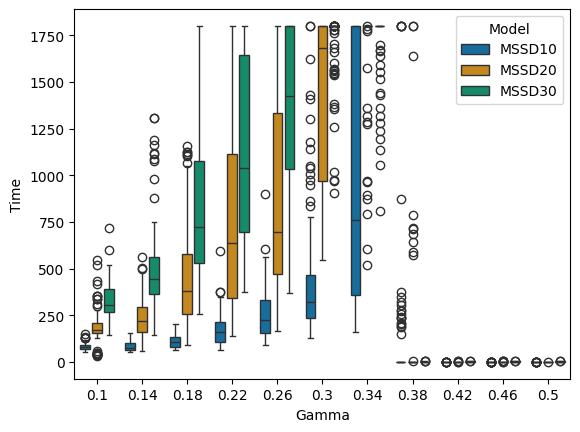

In [12]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter 
def plot_spotify(path):
    df = pd.read_csv(path)
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['Model'] = df['model_name']
    
    # plt.scatter(df['target_prob'], df['time'], s = 1)
    # ticks = plt.xticks()
    # print(ticks)
    
    sns.boxplot(data=df, x="target_prob", y="time", hue="Model", fill=True, gap=.2, palette=sns.color_palette("colorblind"))
    print(plt.xticks())
    plt.xlabel("Gamma")
    plt.ylabel("Time")
    # plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    plt.suptitle("") # to remove groupby X from pandas
    labels = [round(float(item.get_text()),2) for item in plt.gca().get_xticklabels()]
    plt.gca().set_xticklabels(labels)
    plt.savefig(f'out/grouped_boxplot.png')
    # plt.title(n)        
    
plot_spotify('out/results_spotify_1000-3000.csv')

{'3000', '4000', '1000', '2000'}


/tmp/ipykernel_16120/4174135292.py:12: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=df, x="Model", y="gap", hue="Model", fill=True, gap=.2, palette=sns.color_palette("colorblind"))


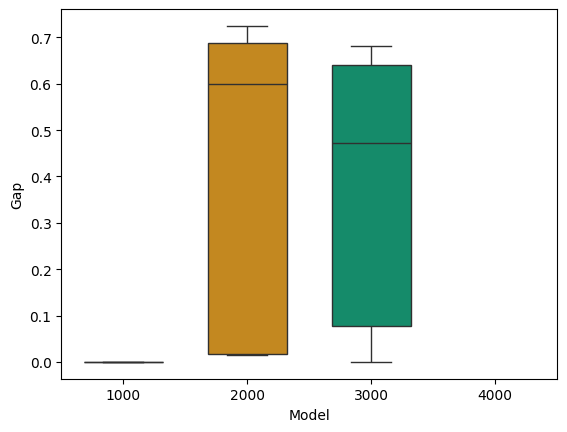

In [13]:
# plot for runtime, by spotify version and gap development
def plot_spotify(path):
    df = pd.read_csv(path)
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0].str[-4:]
    target = ['1000', '2000', '3000', '4000']
    df = df[df['model_name'].str.contains('|'.join(target))]
    df['Model'] = df['model_name']
    df = df[df['gap']!= 0]
    df = df[df['gap']!= 'inf']
    print(set(df['model_name'].values))
       
    sns.boxplot(data=df, x="Model", y="gap", hue="Model", fill=True, gap=.2, palette=sns.color_palette("colorblind"))
    plt.xlabel("Model")
    plt.ylabel("Gap")
    plt.suptitle("") # to remove groupby X from pandas
    plt.savefig(f'out/gap_boxplot.png')
    
plot_spotify(spotify_path)

# Diverse counterfactual strategies

In [ ]:
# plot counterfactual
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import copy 

import solver
from benchmarks import plot_changes, evaluate_strategy, textual_strategy, get_chosen_state_action, strategy_diff

def get_connection(g):
    for s in g:
        if len(list(g[s]))!= 1:
            continue
        assert(len(list(g[s]))==1)
        v = list(g[s])[0]

        edges = list(g.in_edges(v))
        if len(edges) == 1:
            s1 = edges[0][0]
            v1 = edges[0][1]
            assert(s == s1 and v == v1)
            return (s1, v1) # todo correct?
    return None

# Function to merge all 1:1 edges, produces a smaller plot
def merge_connections(g):
    g = copy.deepcopy(g)
    
    edge = get_connection(g)
    print(edge)
    while(edge != None):
        print("merged", edge)
        g = nx.contracted_nodes(g, edge[0], edge[1])
        g.remove_edges_from(nx.selfloop_edges(g))
        edge = get_connection(g)
        
    return g

def draw_dfg(g, name, layout = "sfdp"):
    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*1
        e.attr["fontsize"] = "100"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
    for n in A.nodes():
        n.attr['label'] = ""
        n.attr["fontsize"] = "100"
        n.attr["penwidth"] = "40"
        
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
test_path = 'model_bpic12_model-it_0'
with open(f'out/models/{test_path}.pickle', 'rb') as handle:
    model = pickle.load(handle)
with open(f'out/user_strategies/{test_path}_it_0.pickle', 'rb') as handle:
    user_strategy = pickle.load(handle)
    
draw_dfg(merge_connections(model), f'out/{"bpic17-1"}.png', layout="dot")
  
r_qp = solver.QuadraticProblem(model, 0.09, user_strategy, timeout=100, debug=False).solve()
r_div = solver.QuadraticProblem(model, 0.09, user_strategy, timeout=100, debug=False).solve_diverse([r_qp])
# r_qp = benchmarks.quadratic_program(model, 0.35, user_strategy, timeout=100, debug=False)

# plot_changes(merge_connections(model), "changes", user_strategy, r_qp.strategy, layout="dot")

print("initial", round(evaluate_strategy(model, user_strategy),2))
textual_strategy(user_strategy, r_qp.strategy)

changed_states = set([s[0] for s in get_chosen_state_action(user_strategy, [r_qp, r_div])])
print(changed_states)
l = [(nx.shortest_path_length(model, s, s1), s) for s in changed_states for s1 in changed_states if nx.has_path(model, s, s1)]
print("l", l)
m = max(l, key = lambda x : x[0])
#m (2, 'q24: customerO_CANCELLED')
print("m", m)

print('new states', list(nx.dfs_preorder_nodes(model, source = m[1], depth_limit=m[0]+2)))

remaining_states = []
for i in range(m[0] + 2):
    for s in nx.descendants_at_distance(model, m[1], i):
        remaining_states.append(s)

print((m[0]+2))
sub_model = model.subgraph(remaining_states)

plot_changes(sub_model, "diversity_traversals", user_strategy, [r_qp.strategy, r_div.strategy], layout="dot")

strategy_diff(user_strategy, r_qp.strategy)

print("1", r_qp.value)
print("2", r_div.value)

## Diversity comparison plots

In [15]:
import matplotlib 
def diversity_plots(path, column, y_title):
    df = pd.read_csv(path)
    df['model_name'] = df['path'].str.split('model_').str[1].str.split('_').str[0]
    df['model_name'] = df['model_name'].apply(transform_model_name)
    df['Model'] = df['model_name']
    
    print(df.groupby(['Model']).size())
    
    # sort out infeasible results
    df = df[df['status'].isin([GRB.SUBOPTIMAL, GRB.OPTIMAL])]

    # small values can faster be computed and thus reduce the avg
    # grouped = df.groupby(['path', 'target_prob'])
    # df = grouped.filter(lambda x: x['path'].count() == 3)
    df = df[df['id'] <= 3]
    
    ax = sns.boxplot(data=df, x="Model", y=column, hue="id", fill=True, gap=.2, palette=sns.color_palette("colorblind"))
    ax.legend(title = "Counterfactual", loc = "upper right")
    plt.xlabel("Model")
    plt.ylabel(y_title)
    plt.suptitle("") # to remove groupby X from pandas
    plt.savefig(f'out/diversity/diverse_agg_{column}.png')
    plt.title("agg")
    plt.show()
        
    for m in set(df['Model'].values): 
        print(m)
        #ax = sns.boxplot(data=df, x="id", y="value", hue="target_prob", fill=True, gap=.2)
        
        df_sub = df[df['Model'] == m]
        ax = sns.boxplot(data=df_sub, x="id", y=column, hue="target_prob", fill=True, gap=.2)
        plt.xlabel("Counterfactual")
        ax.legend(title = "γ", loc = "upper right")
        plt.ylabel(y_title)
        plt.suptitle("") # to remove groupby X from pandas
        plt.savefig(f'out/diversity/diverse_{column}_{m}.png')
        plt.title(m)
        plt.show()

Model
BPIC'12    330
BPIC'17    310
Greps      290
dtype: int64


/tmp/ipykernel_16120/3047015227.py:18: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=df, x="Model", y=column, hue="id", fill=True, gap=.2, palette=sns.color_palette("colorblind"))


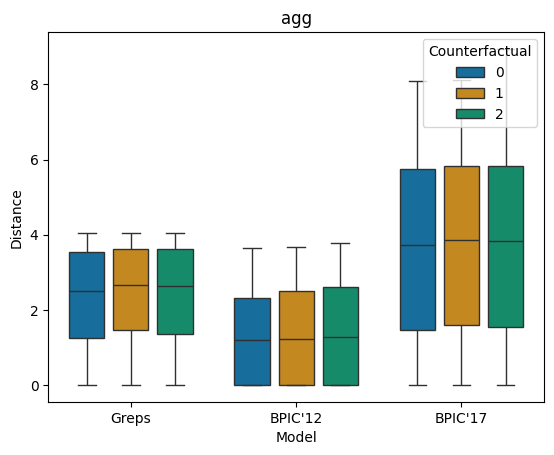

BPIC'17


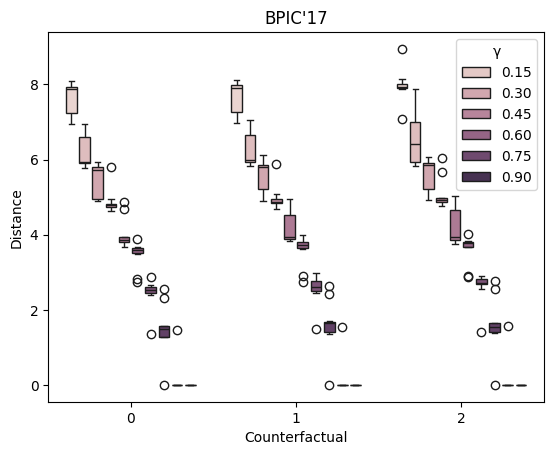

BPIC'12


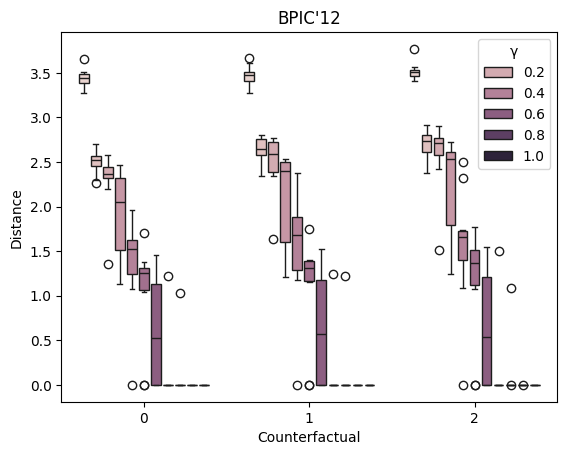

Greps


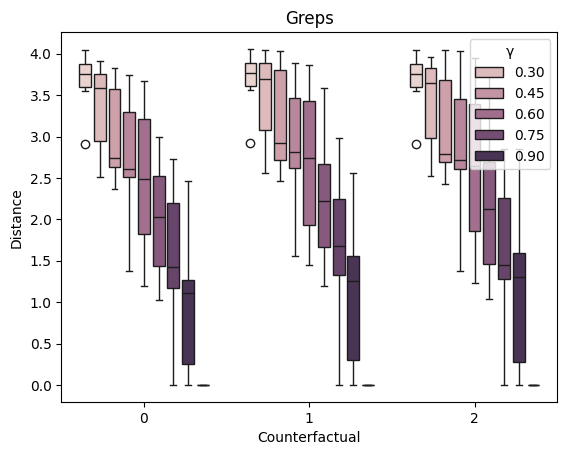

In [16]:
diversity_plots('out/results_div_bpic.csv', 'value', 'Distance')

Model
BPIC'12    330
BPIC'17    310
Greps      290
dtype: int64


/tmp/ipykernel_16120/3047015227.py:18: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=df, x="Model", y=column, hue="id", fill=True, gap=.2, palette=sns.color_palette("colorblind"))


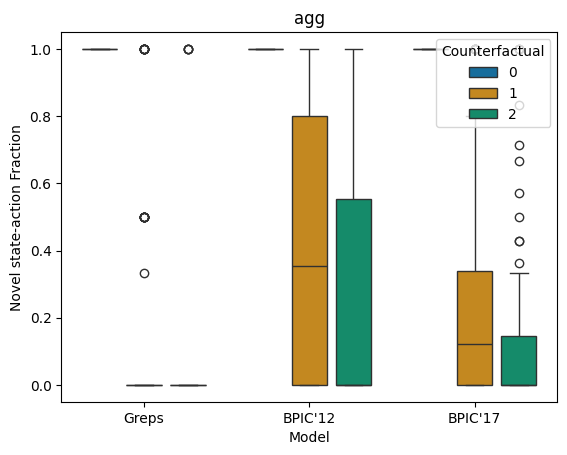

BPIC'17


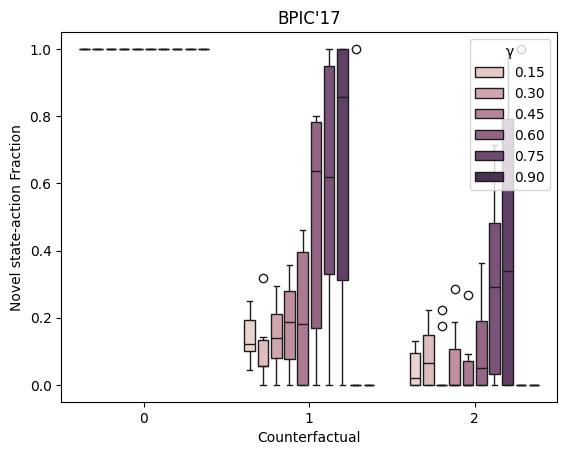

BPIC'12


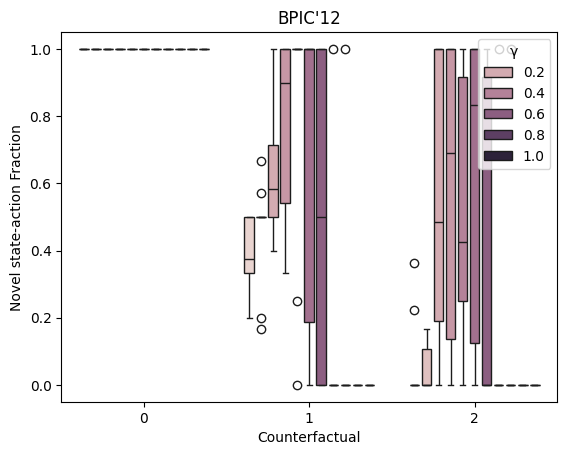

Greps


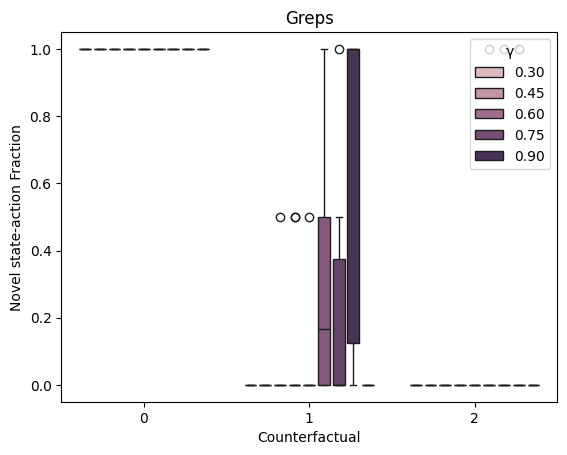

In [17]:
diversity_plots('out/results_div_bpic.csv', 'unknown_fraction', 'Novel state-action Fraction')

Model
BPIC'12    330
BPIC'17    310
Greps      290
dtype: int64


/tmp/ipykernel_16120/3047015227.py:18: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.boxplot(data=df, x="Model", y=column, hue="id", fill=True, gap=.2, palette=sns.color_palette("colorblind"))


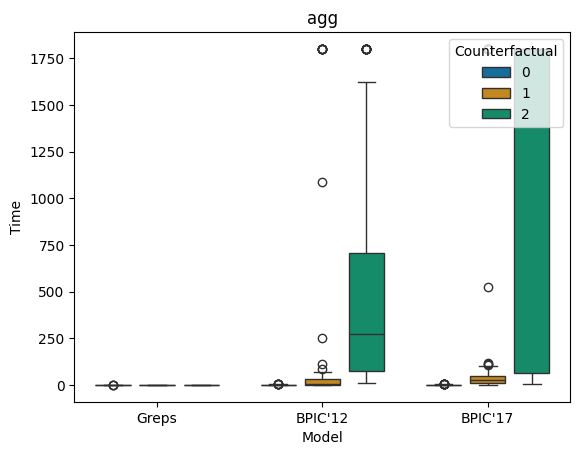

BPIC'17


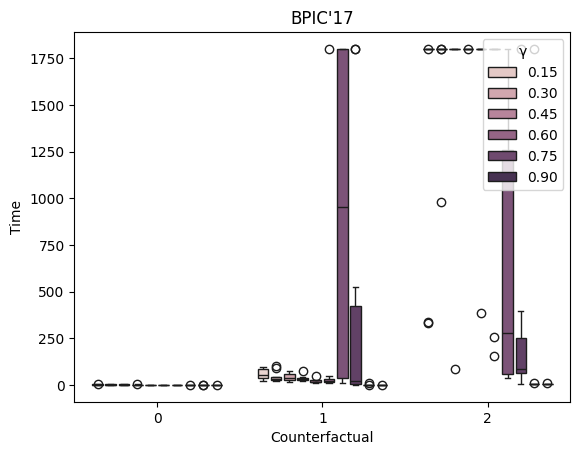

BPIC'12


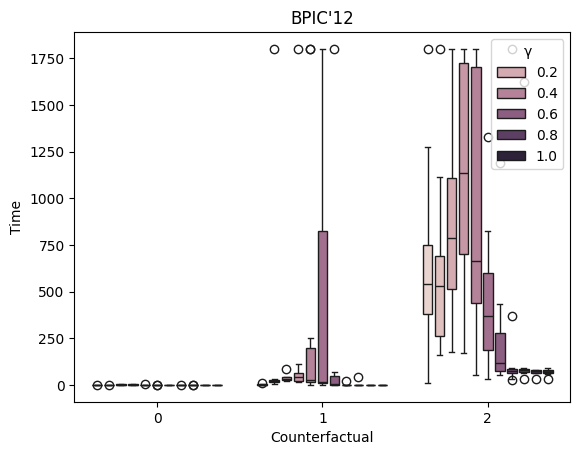

Greps


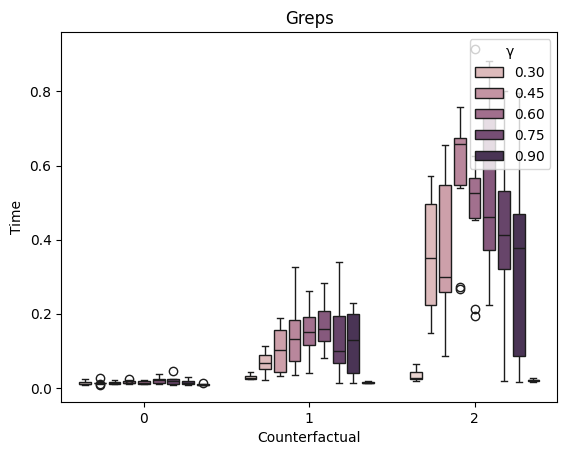

In [18]:
diversity_plots('out/results_div_bpic.csv', 'time', 'Time')